<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task5(Pro)_RNN_%D0%B8_CNN_%D0%B2_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B5_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pro**

#Классификация текстов писателей

**1. Импорт библиотек.**

In [ ]:
from google.colab import files
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Загрузка базы текстов.**

In [ ]:
!rm -R '/content/texts' #remove texts directory
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Тексты писателей.zip' -d '/content/texts' #unzip to created `texts` directory

In [ ]:
def readtext(file_name): #read all text in 1 raw
  file=open(file_name, 'r')
  text=file.read()
  text=text.replace("\n"," ")
  return text

In [ ]:
authors = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] #list of unique authors
authors_qty=len(authors)
authors_qty

6

In [ ]:
train_text=[]
test_text=[]

for i in authors:
  for t in os.listdir('/content/texts/Тексты писателей'):
    if i in t:
      if "Обучающая" in t:
        train_text.append(readtext('/content/texts/Тексты писателей/'+t))
      else:
        test_text.append(readtext('/content/texts/Тексты писателей/'+t))
print(len(train_text))
print(len(train_text[0]))

6
1049517


**3. Нормирование и преобразование данных.**

In [ ]:
max_words_qty=50000
toks=Tokenizer(num_words=max_words_qty, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=" ",
                 oov_token='unknown', char_level=False) #create tokenizer model based on words frequency
toks.fit_on_texts(train_text) #apply tokens to train texts
freq_items=list(toks.word_index.items()) #extracting words with their indexes
print(len(freq_items))
freq_items[:20]

133070


[('unknown', 1),
 ('и', 2),
 ('в', 3),
 ('не', 4),
 ('я', 5),
 ('что', 6),
 ('на', 7),
 ('с', 8),
 ('он', 9),
 ('а', 10),
 ('как', 11),
 ('то', 12),
 ('это', 13),
 ('но', 14),
 ('все', 15),
 ('у', 16),
 ('по', 17),
 ('его', 18),
 ('к', 19),
 ('так', 20)]

In [ ]:
train_word_indexes=toks.texts_to_sequences(train_text) #convert train texts into indexes
test_word_indexes=toks.texts_to_sequences(test_text) #convert test texts into indexes
print(test_text[0][:100])
print(test_word_indexes[0][:20])

﻿Багдадская птица   Без всякого сомнения, дух и гений калифа Гаруна аль-Рашида осенил маркграфа Авгу
[1, 1501, 99, 1152, 1972, 1146, 2, 4039, 1, 1, 28567, 1, 1, 1, 4302, 14023, 8115, 1, 1, 4081]


**4. Создание обучающей и проверочной выборки.**

In [ ]:
def getSetIndexes(wordIndexes, xLen, step): #cut separate author's text into xLen samples
  x_sample=[]
  wordslen=len(wordIndexes)
  index=0
  while (index+xLen)<=wordslen:
    x_sample.append(wordIndexes[index:index+xLen])
    index+=step
  return x_sample

In [ ]:
def getAllSetsIndexes(wordIndexes, xLen, step): #create X set cut into defined length of samples and Y set with correspond author within all authors
  classes=len(wordIndexes) #6 authors
  class_x_sample=[]
  for w in wordIndexes: #take each list of 6 lists
    class_x_sample.append(getSetIndexes(w, xLen, step)) #cut each text list into samples and append to summary list of lists

  X_sam=[]
  Y_sam=[]
  for c in range(classes): #within 6 authors
    cx=class_x_sample[c] #all cut samples of each author's list
    for x in range(len(cx)): #within qty of all samples of each author
      X_sam.append(cx[x]) #append all cut samples to final list
      Y_sam.append(utils.to_categorical(c, classes)) #append all correspond author's vectors to final list

  X_sam=np.array(X_sam)
  Y_sam=np.array(Y_sam)
  return (X_sam, Y_sam)

In [ ]:
xLen=5000
step=100
x_train, y_train=getAllSetsIndexes(train_word_indexes, xLen, step)
x_test, y_test=getAllSetsIndexes(test_word_indexes, xLen, step)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(17400, 5000)
(17400, 6)
(6446, 5000)
(6446, 6)


**5. Распознавание проверочной выборки**

In [ ]:
def createTestMultiClasses(wordIndexes, xLen, step):
  classes=len(wordIndexes) #6 authors
  x_test_classes01=[]
  x_test_classes=[]
  for w in wordIndexes: #take each list of 6 lists
    sample=(getSetIndexes(w, xLen, step)) #cut each author text list into samples
    x_test_classes.append(sample) #and append to summary list of lists
    x_test_classes01.append(toks.sequences_to_matrix(sample)) #convert cut text to bag of words vector and add to the list of lists
  x_test_classes=np.array(x_test_classes, dtype=object)
  x_test_classes01=np.array(x_test_classes01, dtype=object)
  return x_test_classes01, x_test_classes

In [ ]:
def recognizeMultiClass (model, xTest):
  total_sum=0
  for i in range(authors_qty):
    pred=model.predict(xTest[i])
    max_pred=np.argmax(pred, axis=1)
    val=[]
    for j in range(authors_qty):
      val.append(len(max_pred[max_pred==j])/len(xTest[i]))
    total_sum+=len(max_pred[max_pred==i])
    recognizedClass=np.argmax(val)

    isrecognized="Wrong"
    if recognizedClass==i:
      isrecognized="Correct!"
    str1= "Author: "+authors[i]+ " "*(11-len(authors[i]))+str(int(100*val[i]))+"% were cerognized for "+authors[recognizedClass]
    print(str1, " "*(55-len(str1)), isrecognized, sep='')

  sum_count=0
  for i in range(authors_qty):
    sum_count+=len(xTest[i])
  print('\n')
  print("Average % of prediction: ", int(100*total_sum/sum_count),"%", sep='')

  return total_sum/sum_count

**6. Создание и обучение сети.**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5000, 10)          500000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 5000, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 400)               20000400  
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 2

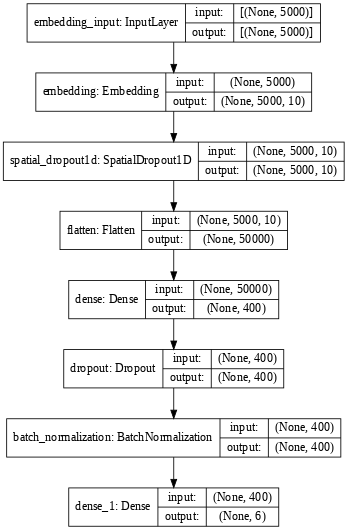

In [ ]:
modelED=Sequential()
modelED.add(Embedding(max_words_qty, 10, input_length=xLen))
modelED.add(SpatialDropout1D(0.2))
modelED.add(Flatten())
modelED.add(Dense(400, activation='relu'))
modelED.add(Dropout(0.2))
modelED.add(BatchNormalization())
modelED.add(Dense(6, activation='sigmoid'))

modelED.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelED.summary()
print()
plot_model(modelED, dpi=60, show_shapes=True)

In [ ]:
modelED.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
136/136 [==============================] - 9s 53ms/step - loss: 0.3813 - accuracy: 0.8732 - val_loss: 1.1802 - val_accuracy: 0.5926
Epoch 2/10
136/136 [==============================] - 7s 51ms/step - loss: 0.0075 - accuracy: 0.9986 - val_loss: 0.8957 - val_accuracy: 0.6922
Epoch 3/10
136/136 [==============================] - 7s 51ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.8979 - val_accuracy: 0.6514
Epoch 4/10
136/136 [==============================] - 7s 52ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.9036 - val_accuracy: 0.6694
Epoch 5/10
136/136 [==============================] - 7s 53ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.8540 - val_accuracy: 0.6913
Epoch 6/10
136/136 [==============================] - 7s 52ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.0965 - val_accuracy: 0.6472
Epoch 7/10
136/136 [==============================] - 7s 52ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.8439 - val_accuracy: 0.7097

In [ ]:
x1,x_test_classes=createTestMultiClasses(test_word_indexes, xLen, step)
scoresDE=recognizeMultiClass(modelED, x_test_classes)
print(scoresDE)

Author: О. Генри   57% were cerognized for О. Генри    Correct!
Author: Стругацкие 78% were cerognized for Стругацкие  Correct!
Author: Булгаков   50% were cerognized for Булгаков    Correct!
Author: Саймак     40% were cerognized for Саймак      Correct!
Author: Фрай       80% were cerognized for Фрай        Correct!
Author: Брэдберри  81% were cerognized for Брэдберри   Correct!


Average % of prediction: 69%
0.6985727582997208


In [ ]:
# разбиваем на 500 блоков по 100 слов в каждом, исключая слова с индексом 1, которые находятся вне словаря.
blocks=[]
index=1
sto=100
sample=[]
for i in freq_items[:50000]:
  if i[1]>1:
    sample.append(i[1])
    index+=1
    if index==sto:
      blocks.append(sample)
      sample=[]
      sto+=100

In [ ]:
# предиктим тестовую выборку с поочередно отключенными блоками и собераем итоговую подборку слов, улучшающих точность (исключение которых давало падение точности).
predictions=[]
block_ups=[]
for block in blocks:
  test_word_indexes_new=[]
  for t in test_word_indexes:
    t_new=[]
    for val in t:
      if val in block:
        t_new.append(0)
      else:
        t_new.append(val)
    test_word_indexes_new.append(t_new)
  x_test_new, y_test_new=getAllSetsIndexes(test_word_indexes_new, xLen, step)
  scores_new=modelED.evaluate(x_test_new,y_test_new, verbose=0)
  predictions.append(scores_new[1])
  if scores_new[1]<scoresDE:
    block_ups.append(block)

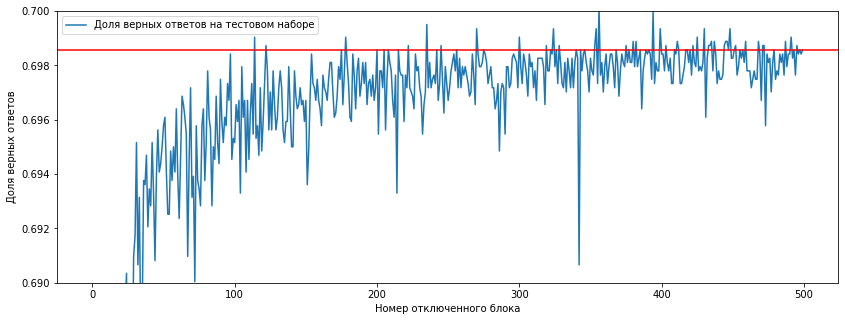

In [ ]:
plt.figure(figsize = (14, 5))
plt.plot(predictions, 
         label='Доля верных ответов на тестовом наборе')
plt.axhline(y=0.6985727582997208, color='r', linestyle='-')
plt.ylim(0.69, 0.7)
plt.xlabel('Номер отключенного блока')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
len(block_ups)

460

In [ ]:
# модифицируем в один блок
block_ups_flat=sum(block_ups, [])
len(block_ups_flat)

45999

In [ ]:
# оцифровываем тестовый текст с учетом отключенных слов
test_word_indexes_final=[]
for t in test_word_indexes:
  t_new=[]
  for val in t:
    if val in block_ups_flat or val==1:
      t_new.append(val)
    else:
      t_new.append(0)
  test_word_indexes_final.append(t_new)

In [ ]:
# оцифровываем тренировочный текст с учетом отключенных слов
train_word_indexes_final=[]
for t in train_word_indexes:
  t_new=[]
  for val in t:
    if val in block_ups_flat or val==1:
      t_new.append(val)
    else:
      t_new.append(0)
  train_word_indexes_final.append(t_new)

In [ ]:
# создаем тренировочную и тестовую выборки с отключенными словами
xLen=5000
step=100
x_train_b, y_train_b=getAllSetsIndexes(train_word_indexes_final, xLen, step)
x_test_b, y_test_b=getAllSetsIndexes(test_word_indexes_final, xLen, step)
print(x_train_b.shape)
print(y_train_b.shape)
print(x_test_b.shape)
print(y_test_b.shape)

(17400, 5000)
(17400, 6)
(6446, 5000)
(6446, 6)


In [ ]:
# обучаем такую же модель на выборках с отключенными словами
modelED_b=Sequential()
modelED_b.add(Embedding(max_words_qty, 10, input_length=xLen))
modelED_b.add(SpatialDropout1D(0.2))
modelED_b.add(Flatten())
modelED_b.add(Dense(400, activation='relu'))
modelED_b.add(Dropout(0.2))
modelED_b.add(BatchNormalization())
modelED_b.add(Dense(6, activation='sigmoid'))

modelED_b.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelED_b.fit(x_train_b, y_train_b, epochs=10, batch_size=128, validation_data=(x_test_b, y_test_b), verbose=1)

Epoch 1/10
136/136 [==============================] - 8s 53ms/step - loss: 0.3815 - accuracy: 0.8744 - val_loss: 1.1397 - val_accuracy: 0.6744
Epoch 2/10
136/136 [==============================] - 7s 50ms/step - loss: 0.0084 - accuracy: 0.9989 - val_loss: 0.9088 - val_accuracy: 0.7004
Epoch 3/10
136/136 [==============================] - 7s 52ms/step - loss: 0.0045 - accuracy: 0.9994 - val_loss: 0.8304 - val_accuracy: 0.7102
Epoch 4/10
136/136 [==============================] - 7s 51ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.9326 - val_accuracy: 0.6939
Epoch 5/10
136/136 [==============================] - 7s 52ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.8745 - val_accuracy: 0.7110
Epoch 6/10
136/136 [==============================] - 7s 52ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.9077 - val_accuracy: 0.7068
Epoch 7/10
136/136 [==============================] - 7s 52ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.9475 - val_accuracy: 0.7107

In [ ]:
x1,x_test_classes_b=createTestMultiClasses(test_word_indexes, xLen, step)
scoresDE_b=recognizeMultiClass(modelED_b, x_test_classes_b)
print(scoresDE_b)

Author: О. Генри   75% were cerognized for О. Генри    Correct!
Author: Стругацкие 47% were cerognized for Стругацкие  Correct!
Author: Булгаков   75% were cerognized for Булгаков    Correct!
Author: Саймак     71% were cerognized for Саймак      Correct!
Author: Фрай       83% were cerognized for Фрай        Correct!
Author: Брэдберри  82% were cerognized for Брэдберри   Correct!


Average % of prediction: 74%
0.7451132485262179


Выводы:
- в общем удалось увеличить точность модели на 5% за счет отключения блоков слов из словаря, количество таких блоков было 40, в основном это были блоки содержащие слова с низкой частотностью.
- так как архитектура с Embedding данной модели для этого задания не устойчивая и при повторном запуске изначальная точность модели может падать до 5%, потому набор и количество таких блоков тоже будет меняться, чем меньше будет количество блоков, отключение которых увеличивают точность модели, тем ниже будет разница в точности между сетью с обучением на полном словаре и сеткой обученной с отключенными блоками.